## Front Matter
- Module name/number: Introduction to Programming for Spatial Analysts/CASA0013
- Student ID:ucfnxfe/20088296
- Title of briefing: The Challenge of Ghost Hotels in Greater London: Evidence from Airbnb
- Word count for the Executive Briefing: 2492 (including figures)


# Reproducible Analysis
### Preparation
#### install and import packages

In [1]:
! pip install gensim

In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora,models,similarities
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt

#### Prepare data

In [3]:
cols = ['id', 'host_id', 'description','neighbourhood_cleansed', 'latitude', 'longitude','room_type', 
        'neighborhood_overview', 'price', 'minimum_nights_avg_ntm', 'reviews_per_month',
        'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']

In [4]:
df = pd.read_csv('https://github.com/Dora-fxh/i2p_FinalProject/raw/main/2020-08-24-listings.csv.gz', compression='gzip', low_memory=False, usecols=cols)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")
# df.to_csv('data/raw/2020-08-24-listings.csv', index=False)

Data frame is 74,188 x 13


### Data cleaning
#### Counting Nulls by Column

In [5]:
df.isnull().sum(axis=0).sort_values(ascending=False)

neighborhood_overview                           26980
reviews_per_month                               20287
description                                      2859
calculated_host_listings_count_shared_rooms         4
calculated_host_listings_count_private_rooms        4
minimum_nights_avg_ntm                              2
price                                               2
room_type                                           2
longitude                                           2
latitude                                            2
neighbourhood_cleansed                              2
id                                                  2
host_id                                             0
dtype: int64

#### Identifying Problem Rows
Firstly, we check for the NaN for "id". From the output of following code, except the items which are Nan, the value of "host_id", "latitude" and "longitude" is strange. Additionally, many other columns are even not the proper data type (eg: neighbourhood_cleansed, minimum_nights_avg_ntm, room_type ). Thus, we can say this two rows are clearly wrong and will be delete diretly.

In [6]:
df[df.id.isna()]

,id,description,neighborhood_overview,host_id,neighbourhood_cleansed,latitude,longitude,room_type,price,minimum_nights_avg_ntm,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3559,NaN,https://a0.muscache.com/im/pictures/user/1c171...,https://a0.muscache.com/im/pictures/user/1c171...,1.0,2,2.0,2.0,15,0,2017-08-12,NaN,NaN,NaN
29990,NaN,https://a0.muscache.com/im/pictures/user/19315...,https://a0.muscache.com/im/pictures/user/19315...,1.0,2,2.0,2.0,1125,10,2020-08-20,NaN,NaN,NaN


In [7]:
df.drop(df[df.id.isna()].index.values, axis=0, inplace=True)

Next, we will check for rows that are causing most of the problems. From following code, we find two rows (29989 and 3558) have 10 NaNs. Simultaneously, after deleting rows whose id is NaN, there are exactly ten colunms which have two NaNs separately, so we assume they are in the same rows. The result is verified by outputing the rows whose latitude and longitude is null. Therefore, these two rows which lost much important information are also deleted.

In [8]:
df.isnull().sum(axis=1).sort_values(ascending=False)

29989    9
3558     9
59291    3
51412    3
59317    3
        ..
38377    0
38376    0
38374    0
38367    0
0        0
Length: 74186, dtype: int64

In [9]:
df[df.longitude.isna() & df.latitude.isna()]

,id,description,neighborhood_overview,host_id,neighbourhood_cleansed,latitude,longitude,room_type,price,minimum_nights_avg_ntm,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3558,3138549.0,Our lovely flat is in a newly designed buildin...,"Old Street is in the heart of Shoreditch, with...",4968944.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29989,21549106.0,Welcome to my Richmond (not East Twickenham) b...,Richmond is famous for its Royal parks & impre...,123942428.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.drop(df[df.longitude.isna()].index.values, axis=0, inplace=True)

#### Fixing the Remaining Data Issues
Adjust the type and content of the columns for our further calculation.             

In [11]:
df.minimum_nights_avg_ntm = df.minimum_nights_avg_ntm.astype('float')
#a value of 3 nights per booking was used if a listing has a lower minimum nights value than 3.
df.loc[df["minimum_nights_avg_ntm"] < 3, "minimum_nights_avg_ntm"] = 3 
df['reviews_per_month']=df['reviews_per_month'].fillna(0).astype('float')
df[["longitude","latitude"]] = df[["longitude","latitude"]].apply(pd.to_numeric,errors='coerce')
# use the sum of private and shared rooms as the total rooms owned by host
df["calculated_host_listings_count_rooms"] = df["calculated_host_listings_count_private_rooms"].fillna(0) + df["calculated_host_listings_count_shared_rooms"].fillna(0)
df["price"]=df["price"].str.replace('$','').str.replace(",",'').astype('float')
houseList = df.loc[df["room_type"].isin(["Private room","Shared room"]),["id","host_id","description","neighborhood_overview","longitude","latitude","calculated_host_listings_count_rooms","neighbourhood_cleansed"]]

In [12]:
df.groupby('neighbourhood_cleansed')['room_type'].value_counts()
#df[(df.room_type=='Private room') | (df.room_type=='Shared room')].neighbourhood_cleansed.value_counts()

neighbourhood_cleansed  room_type      
Barking and Dagenham    Private room        271
                        Entire home/apt     105
                        Shared room           4
                        Hotel room            1
Barnet                  Private room        834
                                           ... 
Wandsworth              Hotel room            7
Westminster             Entire home/apt    6297
                        Private room       2039
                        Hotel room           76
                        Shared room          55
Name: room_type, Length: 125, dtype: int64

### Find ghost hotels and rooms
#### Helper methods
if there are same ids in different sublist, merge the sublist

In [13]:
def mergeSubList(initiallist):
    length = len(initiallist)
    for init1 in range(length):
        for init2 in range(init1 + 1, length):
            if initiallist[init1] == [0]:
                break
            if initiallist[init2] == [0]:
                continue
            # to see whether the two sublists have same elements
            x = list(set(initiallist[init1]+initiallist[init2]))
            y = len(initiallist[init1]) + len(initiallist[init2])                
            if len(x) < y:
                initiallist[init2] = [0]
                initiallist[init1] = x
    return initiallist

#### Perform text similarity


In [14]:
stopWords = set(stopwords.words('english'))
def gensimSimilarities(test, textList):
    # if textList only contain one element, we take turns to use the two text as test 
    if len(textList)==1:
        sim = [max(gensimilarities(test, textList))]
        textList.append(test)
        test = textList.pop(0)
        sim.append(max(gensimilarities(test, textList)))
        # use the small one as the similarity
        sim = min(sim)
    else:
        sim = max(gensimilarities(test, textList))
    return sim
def gensimilarities(test,textList):
    # use tf-idf to construst the importance of the words, and use the gensim to calculate the similarity
    allWordsList = []
    # when there are only one element, the function will always return 0
    if len(textList)==1:
        textList.append("0")
    for text in textList:
        # separate the words and exclude the words in stopwords
        wordsList = [word for word in word_tokenize(text) if word not in stopWords]
        allWordsList.append(wordsList)
    dictionary = corpora.Dictionary(allWordsList)
    corpus = [dictionary.doc2bow(wordsList1) for wordsList1 in allWordsList]    
    testWords = dictionary.doc2bow([word for word in word_tokenize(test) if word not in stopWords])
    tfidf = models.TfidfModel(corpus)
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary.keys()))
    sim = index[tfidf[testWords]]
    return sim

if the item in column "neighborhood_overview" is not null, calculate the similarity based on it. Otherwise calculate the similarity on column "description"

In [15]:
def checkDescription(checkroom,ghostHotel):
    checkDf = houseList.loc[houseList["id"]==checkroom,["id", "neighborhood_overview","description"]]
    samehostDf = houseList[houseList["id"].isin(ghostHotel)]
    simlarity1 = 0
    simlarity2 = 0
    overviewDf = samehostDf["neighborhood_overview"].dropna()
    checkOverview = checkDf["neighborhood_overview"].dropna()
    if overviewDf.shape[0]>0 and checkOverview.shape[0] > 0:
        simlarity1 = gensimSimilarities(checkOverview.iloc[0],list(overviewDf))       
    if samehostDf.shape[0] != overviewDf.shape[0]:
        descripDf = samehostDf["description"].dropna()
        checkDesc = checkDf["description"].dropna()
        if descripDf.shape[0]>0 and checkDesc.shape[0] > 0:
            simlarity2 = gensimSimilarities(checkDesc.iloc[0], list(descripDf))
    simlarity = max(simlarity1, simlarity2)
    # if the description of checkroom has simlarity bigger than 0.5 of one text of the ghostHotel, 
    # classify it as ghost hotel`
    if simlarity > 0.5:
        return True
    else:
        return False

#### The main part of finding the ghost hotels
Creat a list called ghostlist which contains all the 'id' for ghost rooms, and each sublist of ghostlist is a ghost hotel.

In [16]:
indexlist = list(houseList.index)
ghostList = []
houseList.loc["ini",["id","host_id","description","neighborhood_overview","longitude","latitude","calculated_host_listings_count_rooms"]] = [0,0,"0","0",0,0,0]
while len(indexlist) > 0 :
    # if one have more than one private or shared rooms on Airbnb, it has the suspicion to be ghost hotels
    if houseList.loc[indexlist[0],"calculated_host_listings_count_rooms"] > 1:
        # find the house which have the same host_id and put them together
        ghostdf = houseList[houseList["host_id"] == houseList.loc[indexlist[0],"host_id"]]
        ghostHost = list(ghostdf['id'])
        # it is a list used to store the ghost hotels list
        initiallist = [[0]]
        for i in ghostdf.index:
            # if there are no rooms within the distance it will still be False
            isghost = False
            for init in initiallist:
                for ini in init:
                    # the longitude and latitude of the rooms in list
                    iniLogLat = (houseList.loc[houseList["id"]==ini,"longitude"].iloc[0],houseList.loc[houseList["id"]==ini,"latitude"].iloc[0])
                    iLonLat = (ghostdf.loc[i,"longitude"],ghostdf.loc[i,"latitude"])
                    # use the longitude and latitude to calculate the distance
                    distance = geodesic(iniLogLat, iLonLat).m
                    # if the distance is less than 200m, we consider it as ghost hotel
                    #(distance of 50 to 500 meters is manually tried and find the optimal one)
                    if distance < 200:
                        init.append(ghostdf.loc[i,"id"])
                        isghost = True
                        break
            if not isghost:
                initiallist.append([ghostdf.loc[i,"id"]])
        
        # use the description to calculate the distance, in case of inaccurate positioning 
        initiallist1 = [[0]]
        for checkroom in ghostHost:
            isghost = False
            for ghostHotel in initiallist1:
                if checkDescription(checkroom,ghostHotel):
                    ghostHotel.append(checkroom)
                    isghost = True
                    break
            if not isghost:
                initiallist1.append([checkroom])
        initiallist.extend(initiallist1)
        initiallist = mergeSubList(initiallist)
        # the list with more than one id is a ghost hotel
        initiallist = [init for init in initiallist if len(init)>1]
       
        ghostList.extend(initiallist)
        # delete the rows that we have already checked
        indexlist = [index for index in indexlist if index not in ghostdf.index]
    else:
        # if the host don't have more than one private or shared rooms, it is not ghost hotels
        del indexlist[0]
houseList.drop("ini",inplace=True)

get the complete information of each ghost room

In [17]:
ghostHotelDf = pd.DataFrame(columns = df.columns)
for rooms in ghostList:
    ghostHotelDf = ghostHotelDf.append(df.loc[df["id"].isin(rooms)])


In [18]:
ghostHotelDf.head()

,id,description,neighborhood_overview,host_id,neighbourhood_cleansed,latitude,longitude,room_type,price,minimum_nights_avg_ntm,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,calculated_host_listings_count_rooms
1,13913.0,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,54730.0,Islington,51.56802,-0.11121,Private room,49.0,3.0,2.0,0.0,0.17,2.0
6326,5693759.0,"Art Studio available in Dalston, East London o...","In the heart of Dalston, full of bars, coffee ...",54730.0,Hackney,51.54850,-0.07131,Private room,88.0,3.0,2.0,0.0,0.05,2.0
4,17506.0,Enjoy a chic stay in this elegant but fully mo...,Fulham is 'villagey' and residential – a real ...,67915.0,Hammersmith and Fulham,51.47935,-0.19743,Private room,150.0,3.0,2.0,0.0,0.00,2.0
1467,787359.0,Enjoy a chic stay in this elegant but fully mo...,Fulham is 'villagy' and residential – Barclay ...,67915.0,Hammersmith and Fulham,51.47883,-0.19816,Private room,168.0,3.0,2.0,0.0,0.00,2.0
5,25123.0,Big room with double bed/ clean sheets/ clean ...,Barnet is one of the largest boroughs in Londo...,103583.0,Barnet,51.57224,-0.20906,Private room,29.0,10.0,3.0,0.0,1.02,3.0


### Visualization part
Plot a stacked figure to show the Composition of Listings in Airbnb.For each borough, the top of each color is the number of its corresponding type of lstings.
#### composition of airbnb listings with respect yo ghost hotel

In [19]:
number1Df = pd.DataFrame(df["neighbourhood_cleansed"].value_counts())
number2Df = pd.DataFrame(houseList["neighbourhood_cleansed"].value_counts())
number3Df = pd.DataFrame(ghostHotelDf["neighbourhood_cleansed"].value_counts())
numberDf = pd.merge(number1Df, number2Df, how='outer',left_index=True,right_index=True)
numberDf = pd.merge(numberDf, number3Df, how='outer',left_index=True,right_index=True)
numberDf.columns = ["total listings","private/shared rooms","ghost hotels"]
numberDf = numberDf.fillna(0)

In [20]:
def stackFigure():
    sns.set_style("white")
    sns.set_context({"figure.figsize": (18, 10)})
    sns.barplot(x = numberDf.index, y = numberDf["total listings"], color = "yellow")
    sns.barplot(x = numberDf.index, y = numberDf["private/shared rooms"], color = "blue")
    ghost_plot = sns.barplot(x = numberDf.index, y = numberDf["ghost hotels"], color = "red")

    raw_data_legend = plt.Rectangle((0,0),1,1,fc="yellow", edgecolor = 'none')
    private_room_legend = plt.Rectangle((0,0),2,1,fc='blue',  edgecolor = 'none')
    ghost_hotel_legend = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'none')
    font = {'weight' : 'normal','size': 20}
    l = plt.legend([raw_data_legend, private_room_legend, ghost_hotel_legend], ["total listings", "private/shared rooms","ghost hotel rooms"], ncol = 1, prop={'size':16},loc='upper left')
    ghost_plot.set_ylabel("The Amount of Rooms",font)
    ghost_plot.set_title("Figure 1: The Composition of Listings on Airbnb of 33 Boroughs in London",fontsize=25)
    plt.yticks(fontsize= 10)
    plt.xticks(rotation=-90, fontsize=14)
    plt.show()

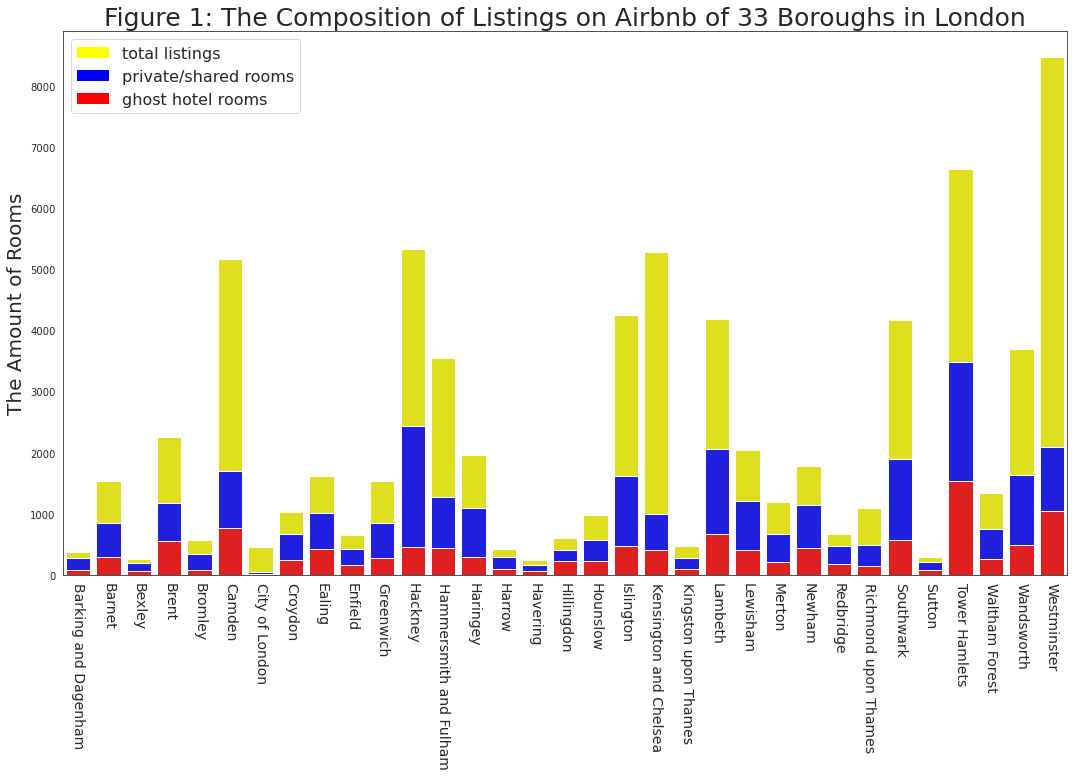

In [21]:
stackFigure()

Find the coordinates and the number of rooms in every ghost hotel

In [22]:
distributionDF = pd.DataFrame(columns=["longitude","latitude","counts",'neighbourhood_cleansed'])
for i,ghost in enumerate(ghostList):
    ghosthotel0 = ghostHotelDf.loc[ghostHotelDf["id"]==ghost[0]]
    distributionDF.loc[i] = [ghosthotel0["longitude"].iloc[0],ghosthotel0["latitude"].iloc[0],len(ghost),ghosthotel0["neighbourhood_cleansed"].iloc[0]]

Find the number of ghost hotels, ghost rooms, and percentage of ghost rooms in total listings in each borough

In [23]:
ghosthotelNeighbor = distributionDF.neighbourhood_cleansed.value_counts()
ghosthotelNeighbor = ghosthotelNeighbor.reset_index()
ghosthotelNeighbor.columns = ["name", "ghost_hotel_number"]

ghostRoomNeighbor=ghostHotelDf.neighbourhood_cleansed.value_counts()
ghostRoomNeighbor = ghostRoomNeighbor.reset_index()
ghostRoomNeighbor.columns = ["name", "ghost_room_number"]

neighborRoomProportion = ghostHotelDf.neighbourhood_cleansed.value_counts()/df.neighbourhood_cleansed.value_counts()
neighborRoomProportion = neighborRoomProportion.reset_index()
neighborRoomProportion.columns = ["name", "ghost_percentage"]


In [24]:
ghosthotelNeighbor.head()
ghostRoomNeighbor.head()

,name,ghost_room_number
0,Tower Hamlets,1529
1,Westminster,1047
2,Camden,766
3,Lambeth,666
4,Southwark,564


#### Distribution of all the listings and ghost rooms

Text(0.5, 1.0, 'distribution for all the listings')

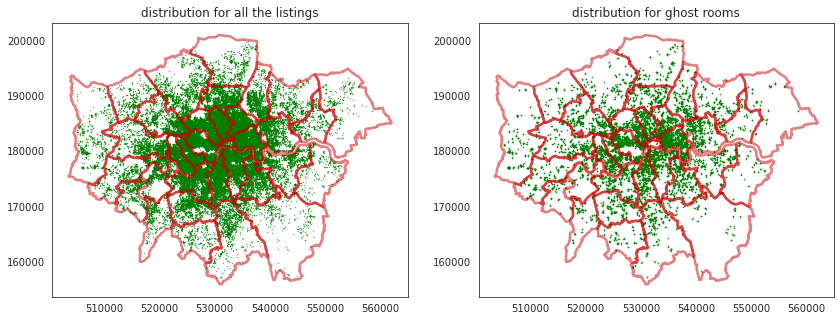

In [25]:
boros = gpd.read_file('data/Boroughs.gpkg' )
Tower_HamletsDF = distributionDF[distributionDF["neighbourhood_cleansed"]=="Tower Hamlets"]
fig, axes = plt.subplots(1,2, figsize=(14,9))

gdf1 = gpd.GeoDataFrame(ghostHotelDf , 
          geometry=gpd.points_from_xy(ghostHotelDf['longitude'], ghostHotelDf['latitude'], crs='epsg:4326'))
gdf1 = gdf1.to_crs("epsg:27700")
gdf1.plot(marker='o',  markersize=0.25, color='green',ax = axes[1], alpha=1
            ,legend=True)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none',linewidth=2.5, ax=axes[1])
axes[1].set_title("distribution for ghost rooms") 
gdf2 = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
gdf2 = gdf2.to_crs("epsg:27700")
gdf2.plot(marker='*', color='green', markersize=0.25, ax = axes[0], alpha=0.6)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none',linewidth=2.5, ax=axes[0])
axes[0].set_title("distribution for all the listings") 

In [26]:
#sort the proportion of ghost hotel in each borough
neighborRoomProportion.sort_values(by='ghost_percentage', ascending=False)

,name,ghost_percentage
16,Hillingdon,0.376026
28,Sutton,0.295302
25,Redbridge,0.267751
8,Ealing,0.261406
24,Newham,0.251268
15,Havering,0.246964
9,Enfield,0.246951
2,Bexley,0.244361
3,Brent,0.243136
7,Croydon,0.240272


merge the boundary and our ghost room proportion data, extract two boroughs we want to dig more

In [27]:
neighborBoros = pd.merge(boros, neighborRoomProportion, left_on='NAME', right_on='name')
Hillingdon_room = ghostHotelDf[ghostHotelDf["neighbourhood_cleansed"]=="Hillingdon"]
Hillingdon_Hotel = distributionDF[distributionDF["neighbourhood_cleansed"]=="Hillingdon"]
Tower_HamletsDF = distributionDF[distributionDF["neighbourhood_cleansed"]=="Tower Hamlets"]
Tower_Hamlets_room= ghostHotelDf[ghostHotelDf["neighbourhood_cleansed"]=="Tower Hamlets"]
bbox = 'POLYGON((503600 173600, 503600 193800, 512800 193800, 512800 173600, 503600 173600))'
bgdf = gpd.GeoDataFrame({'id':[0], 'coordinates':bbox})
bgdf['geometry'] = bgdf.coordinates.apply(wkt.loads)
bgdf = bgdf.set_crs("epsg:27700")

bbox1 = 'POLYGON((533300 178100, 533300 184800, 539500 184800, 539500 178100, 533300 178100))'
bgdf1 = gpd.GeoDataFrame({'id':[0], 'coordinates':bbox1})
bgdf1['geometry'] = bgdf1.coordinates.apply(wkt.loads)
bgdf1 = bgdf1.set_crs("epsg:27700")

The distribution of gost hotels and their proportion in total listings for each borough is combined in one plot.
we will focus on two specific areas, one is Hillington (regions with the highest ghost hotel room rate) and the other is Tower Hamlets boroughs (with the most ghost hotels and rooms). Their enlarged views is on the left and right bottom of the plot.
The dots represents the locations of the ghost hotels and dots with a larger size and lighter colour indicate a ghost hotel with more rooms.

In [28]:
def mainPlot():
    fig, ax = plt.subplots(1,1, figsize=(14,9))
    neighborBoros.plot(edgecolor=(0.5, 0.5, 0.5, 0.5), column='ghost_percentage',linewidth=2.5, cmap='coolwarm', 
             legend=True, ax=ax)

    gdf = gpd.GeoDataFrame(distributionDF , 
          geometry=gpd.points_from_xy(distributionDF ['longitude'], distributionDF ['latitude'], crs='epsg:4326'))
    gdf = gdf.to_crs("epsg:27700")
    gdf.plot(marker='o',  markersize=list(distributionDF['counts']), k=8, cmap='viridis', column='counts',ax = ax, alpha=1
            ,legend=True)
    
    boros[boros.NAME=="Tower Hamlets"].plot(facecolor='none', edgecolor='r', hatch='///', ax=ax)
    boros[boros.NAME=="Hillingdon"].plot(facecolor='none', edgecolor='r', hatch='///', ax=ax)
    
    ax1 = fig.add_axes([0.537, 0.07, 0.32, 0.32])
   
    gdf = gpd.GeoDataFrame(Tower_HamletsDF , 
          geometry=gpd.points_from_xy(Tower_HamletsDF ['longitude'], Tower_HamletsDF ['latitude'], crs='epsg:4326'))
    gdf = gdf.to_crs("epsg:27700")
    gdf.plot(marker='o',  markersize=list(Tower_HamletsDF['counts']), k=8, cmap='viridis', column='counts',ax = ax1)
    boros[boros.NAME=="Tower Hamlets"].plot(edgecolor=(0.5, 0.5, 0.5, 0.5), facecolor='none',linewidth=2.5, ax=ax1)
    bgdf1.plot(ax=ax1, color='none', edgecolor='r', linewidth=2)
    
    ax2 = fig.add_axes([0.006, 0.05, 0.35, 0.35])
    gH = gpd.GeoDataFrame(Hillingdon_Hotel , 
          geometry=gpd.points_from_xy(Hillingdon_Hotel ['longitude'], Hillingdon_Hotel ['latitude'], crs='epsg:4326'))
    gH = gH.to_crs("epsg:27700")
    gH.plot(marker='o',  markersize=list(Hillingdon_Hotel['counts']), cmap='viridis', column='counts',ax = ax2, alpha=1
           )
    boros[boros.NAME=="Hillingdon"].plot(edgecolor=(0.5, 0.5, 0.5, 0.5), facecolor='none',linewidth=2.5, ax=ax2)
    bgdf.plot(ax=ax2, color='none', edgecolor='r', linewidth=2)
    ax.axis('off')
    ax1.axis('off')
    ax2.axis('off')

    ax.set_title('Figure 2: The distribution of gost hotels and \ntheir proportion in total listings for each borough', size=25)
    ax.get_legend().set_title("room number for \n each ghost hotel")  
    ax.get_legend().set_bbox_to_anchor((1.33, 1.02))

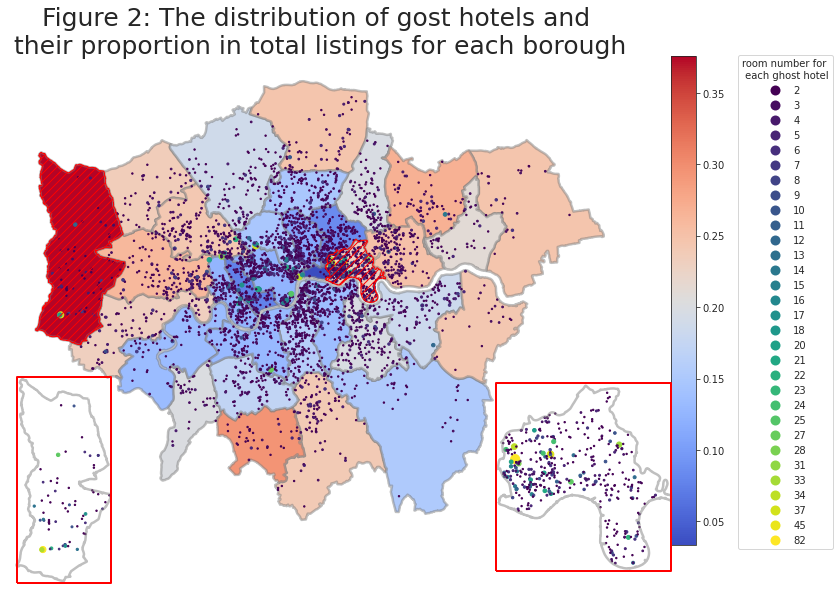

In [29]:
mainPlot()

In [30]:
#gdf_la = gpd.sjoin(gdf, boros, op='within', how='left')

#### the percentage of revenue from ghost room among total listings

In [31]:
def calculate_revenue(dataframe):
    price=dataframe['price']
    minDay = dataframe.minimum_nights_avg_ntm
    review= dataframe['reviews_per_month']
    revenue=sum(review*price*minDay/0.5)
    return revenue

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74184 entries, 0 to 74187
Data columns (total 15 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            74184 non-null  float64 
 1   description                                   71325 non-null  object  
 2   neighborhood_overview                         47204 non-null  object  
 3   host_id                                       74184 non-null  float64 
 4   neighbourhood_cleansed                        74184 non-null  object  
 5   latitude                                      74184 non-null  float64 
 6   longitude                                     74184 non-null  float64 
 7   room_type                                     74184 non-null  object  
 8   price                                         74184 non-null  float64 
 9   minimum_nights_avg_ntm                        7418

In [33]:
total_listing=calculate_revenue(df)
total_ghost=calculate_revenue(ghostHotelDf)
total_Hillingdon=calculate_revenue(df[df.neighbourhood_cleansed=='Hillingdon'])
total_Tower_Hamlets=calculate_revenue(df[df.neighbourhood_cleansed=='Tower Hamlets'])
Hillingdon_ghost=calculate_revenue(Hillingdon_room)
Tower_Hamlets_ghost = calculate_revenue(Tower_Hamlets_room)
print(total_ghost)
print(f"precentage of total ghost hotel's revenue = {total_ghost/total_listing}")
print(Hillingdon_ghost)
print(f"precentage of Tower Hamlets ghostroom's revenue = {Tower_Hamlets_ghost/total_Tower_Hamlets}")
print(Tower_Hamlets_ghost)
print(f"precentage of Hillingdon ghostroom's revenue = {Hillingdon_ghost/total_Hillingdon}")


3989490.0951600047
precentage of total ghost hotel's revenue = 0.0969182993503697
40088.67540000001
precentage of Tower Hamlets ghostroom's revenue = 0.13435996004547474
442808.00304000004
precentage of Hillingdon ghostroom's revenue = 0.20027541502181498


#### visualization for monthly ghost hotel price and long-term one-bedroom rent

In [34]:
rentOne =  pd.read_csv('https://github.com/Dora-fxh/i2p_FinalProject/raw/main/rent.csv.gz', compression='gzip', low_memory=False)
#read the one-bedroom monthly average price in long-term rental market
ghostPriceDf = ghostHotelDf[["neighbourhood_cleansed","price"]][(ghostHotelDf["neighbourhood_cleansed"].isin(["Hillingdon","Tower Hamlets"])) & (ghostHotelDf["price"]<np.percentile(ghostHotelDf["price"], 97.5)) & (ghostHotelDf["price"]>np.percentile(ghostHotelDf["price"], 2.5))]
ghostPriceDf["price"] = ghostPriceDf["price"]*30
#extract the boroughs and columns we need

<AxesSubplot:>

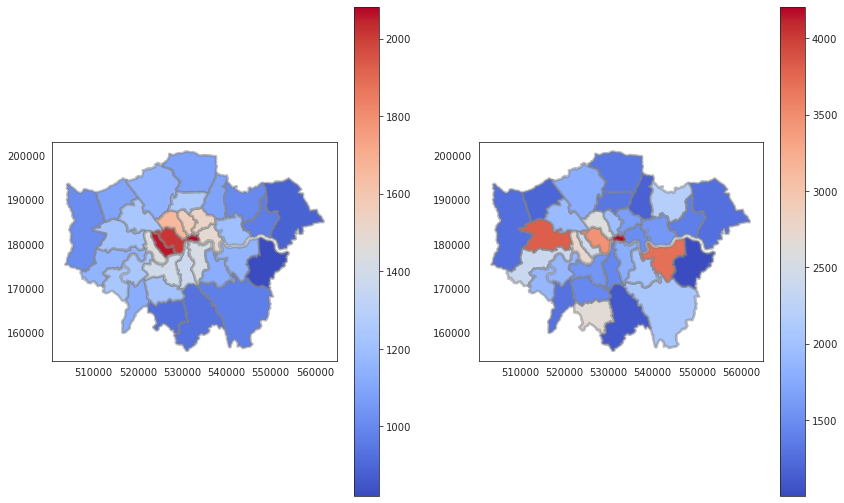

In [35]:
ghostRoomPrice=ghostHotelDf.groupby('neighbourhood_cleansed')['price'].mean()
ghostRoomPrice = ghostRoomPrice.reset_index()
ghostRoomPrice.columns = ["name", "avePrice"]
ghostRoomPrice["avePrice"]=ghostRoomPrice["avePrice"]*30
ghostPriceBoros=pd.merge(boros, ghostRoomPrice, left_on='NAME', right_on='name')
rentPriceBoros=pd.merge(boros, rentOne, left_on='NAME', right_on='Area')

fig, axes = plt.subplots(1,2, figsize=(14,9))
rentPriceBoros.plot(edgecolor=(0.5, 0.5, 0.5, 0.5), column='Average',linewidth=2.5, cmap='coolwarm', 
             legend=True, ax=axes[0])
ghostPriceBoros.plot(edgecolor=(0.5, 0.5, 0.5, 0.5), column='avePrice',linewidth=2.5, cmap='coolwarm', 
             legend=True, ax=axes[1])

compare the long-term rent with average ghost price per month.

In [36]:
comparePriceDf = ghostHotelDf[["neighbourhood_cleansed","price"]]
comparePriceDf = comparePriceDf["price"].groupby(comparePriceDf["neighbourhood_cleansed"]).mean()*30
comparePriceDf = comparePriceDf.reset_index()
comparePriceDf.columns = ["Area", "ghostPrice"]
comparePriceDf = comparePriceDf.join(rentOne[["Area","Average"]].set_index("Area"),how="left",on="Area")
comparePriceDf["times"] = comparePriceDf["ghostPrice"]/ comparePriceDf["Average"]
compPrice=pd.DataFrame({"type":["ghost Price"]*33+["rental price"]*33, "monthPrice":list(comparePriceDf["ghostPrice"])+list(comparePriceDf["Average"])})

In [37]:
comparePriceDf

,Area,ghostPrice,Average,times
0,Barking and Dagenham,1386.296296,965,1.436576
1,Barnet,1786.089965,1147,1.557184
2,Bexley,1003.846154,821,1.222712
3,Brent,1917.727869,1241,1.545309
4,Bromley,2067.225000,972,2.126775
5,Camden,2603.726240,1659,1.569455
6,City of London,4208.280000,2083,2.020298
7,Croydon,1097.992713,931,1.179369
8,Ealing,3814.002594,1216,3.136515
9,Enfield,1331.324074,1083,1.229293


In [38]:
def densityPlot():
    ax2 = plt.subplot(121)
    density=sns.violinplot(data = compPrice, x='type', y='monthPrice',ax=ax2)
    density.set_title('3(a)\ndistribution of ghost hotel price and one-bedroom rent', size=18)
    density.figure.set_size_inches(17,8)
    plt.xlabel("price type", fontsize=13)
    plt.ylabel("monthly price",fontsize=13)
    ax1 = plt.subplot(122)
    plt.suptitle('Figure 3: Distribution of Monthly Price', fontsize=23)
    rentlegend = ax1.scatter(["Tower Hamlets","Hillingdon"], rentOne[rentOne["Area"].isin(["Hillingdon","Tower Hamlets"])][["Average"]].values.flatten(), marker ="_",linewidths=5,s = 500,c="r")
    density=sns.violinplot(data = ghostPriceDf, x='neighbourhood_cleansed', y='price',ax=ax1)
    density.figure.set_size_inches(17,8)
    density.set_title('3(b)\ndistribution of ghost hotel prices in some boroughs', size=18)
    rentprice = ax1.scatter(["Hillingdon","Tower Hamlets"], rentOne[rentOne["Area"].isin(["Hillingdon","Tower Hamlets"])][["Average"]].values.flatten(), marker ="_",linewidths=5,s = 8**5,c="r",zorder=100)
    ax1.legend([rentlegend], ['Monthly Average Rent \n of one bedroom'], loc = 'upper right') 
    plt.ylabel("monthly price",fontsize=13)
    plt.xlabel("borough name",fontsize=13)
    plt.show()

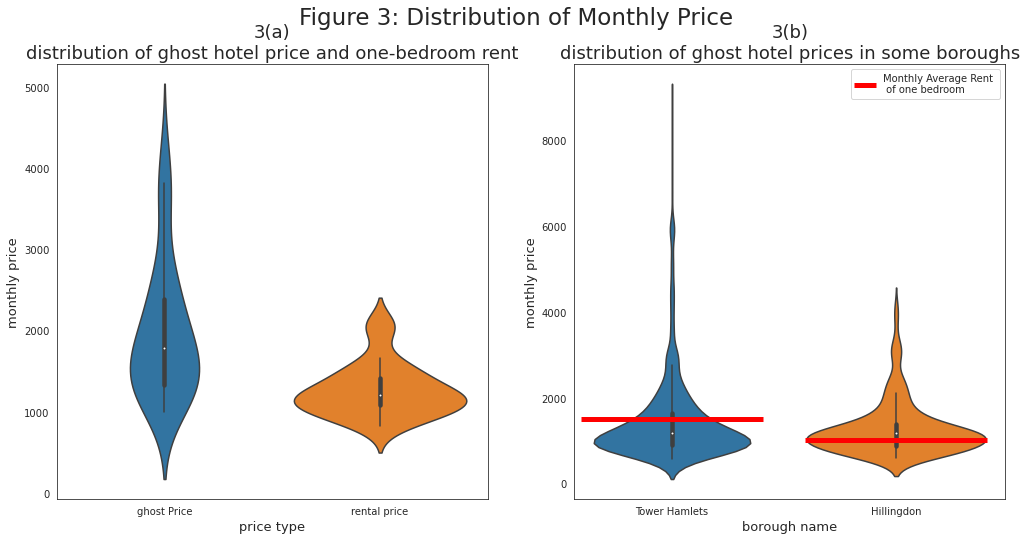

In [39]:
densityPlot()

#### relationship with long-term monthly rent

In [40]:
np.mean(ghostHotelDf.price)

68.58899464604401

In [41]:
totalAvePrice=df.groupby('neighbourhood_cleansed')['price'].mean()
totalAvePrice = totalAvePrice.reset_index()
totalAvePrice.columns = ["name", "avePrice"]

In [42]:
rent = pd.read_csv('https://github.com/Dora-fxh/i2p_FinalProject/raw/main/rentAll.csv.gz', compression='gzip', low_memory=False)
#read the data to get the average monthly rent in the traditional rental market
rentComp=pd.merge(ghostRoomNeighbor, rent, left_on='name', right_on='Area')
rentComp=pd.merge(rentComp, totalAvePrice, left_on='name', right_on='name')
rentComp=pd.merge(rentComp, neighborRoomProportion, left_on='name', right_on='name')
rentComp=rentComp[["ghost_room_number","Count_of_rents","Average", "avePrice","ghost_percentage"]]

In [43]:
#bulit multiply regression model to see the relation between the number and price of ghost rooms and longterm monthly avenue
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
#model_df = sm.formula.ols('ghost_room_number ~  Count_of_rents ', rentComp).fit()
model_df = sm.formula.ols(' Average~  ghost_room_number + avePrice', rentComp).fit()
model_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Average   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     109.2
Date:                Thu, 14 Jan 2021   Prob (F-statistic):           1.70e-14
Time:                        22:37:50   Log-Likelihood:                -216.06
No. Observations:                  33   AIC:                             438.1
Df Residuals:                      30   BIC:                             442.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           364.0586     91.225      3.991      0.000     177.752     550.365
ghost_room_number     0.3503      0.105      3.344      0.002       0.136       0.564
avePrice             11.3053      0.880     12.844      0.000       9.508      13.103
==============================================================================
Omnibus:                        7.999   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.248
Skew:                           0.748   Prob(JB):                       0.0267
Kurtosis:                       4.742   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Correlation Matrix')

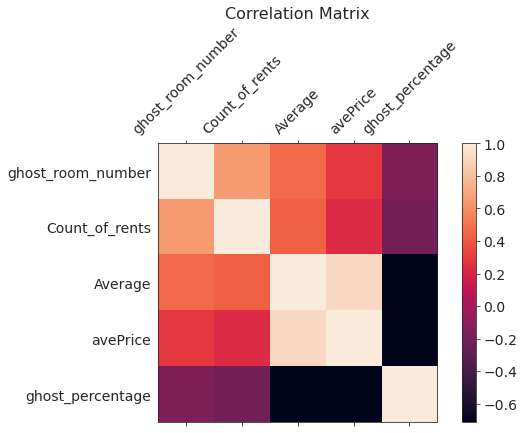

In [44]:
# correlation matrix
df1= rentComp
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(9, 5))
plt.matshow(df1.corr(), fignum=f.number)
plt.xticks(range(df1.shape[1]), df1.columns, fontsize=14, rotation=45)
plt.yticks(range(df1.shape[1]), df1.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
#plt.savefig("corr")

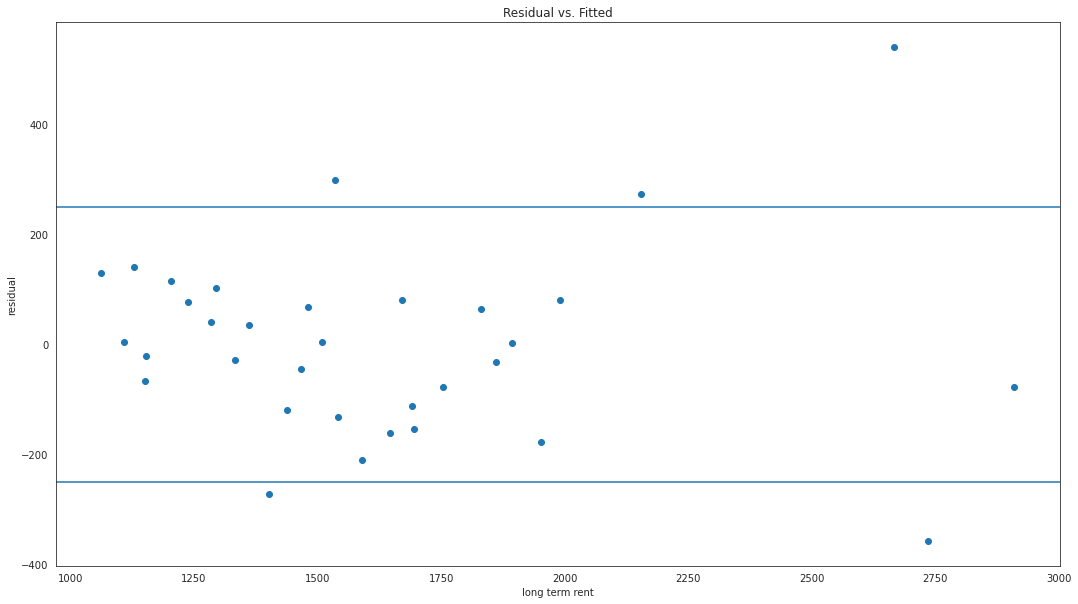

In [45]:
# check the assumption of equal variance by scatter plot of residual
plt.scatter(model_df.fittedvalues, model_df.resid)
# adding title and labels
plt.axhline(250)
plt.axhline(-250)
plt.xlabel('long term rent')
plt.ylabel('residual')
plt.title('Residual vs. Fitted')
plt.show()

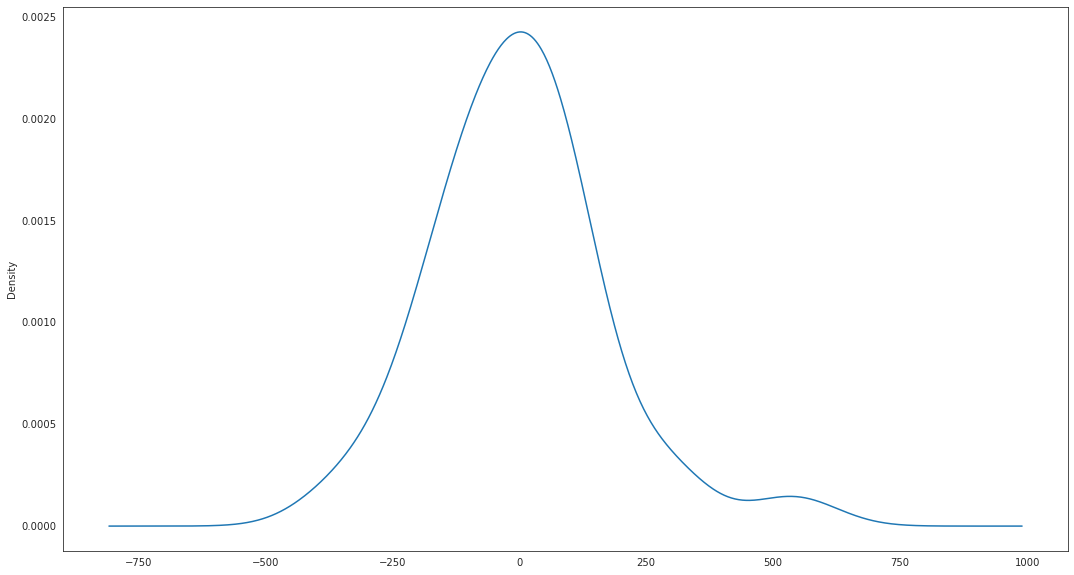

In [46]:
# check the normal distribution of residual
plt.figure()
model_df.resid.plot.density()
plt.show()

# Executive Briefing
## Executive Summary

In the conflict of limitations set to the entire home or apartments and eagerness to earn more money, “ghost hotels” come into vogue. They are private or shared rooms listed individually on short-term rental platform but actually are from the same entire units or buildings. Thus, issues related to ghost hotels in London boroughs will be discussed in several aspects.
1. some more specific reasons of the emergency and growth of ghost hotel.
2. Their distribution will be visualized to help us clearly identify which area has the highest proportion of “ghost rooms” and which regions has the largest number of ghost hotels and rooms. 
3. the potential impact of ghost hotel to local communities and the relationship with long-term rent will be given.
4. some feasible suggestions will be raise.

**key finding**
1. most ghost hotels in London have the tax advantages against the traditional commercial hotels
2. Hillington has the highest ghost hotel room rate and Tower Hamlets boroughs has the most ghost hotels and rooms. Additionally, 13.4% (around 440,000 pound) of the local avenue from listings in Airbnb is earned by ghost hotels for Tower Hamlets, and approximately 20% (just over forty thousand pound) for Hillingdon.
3. the average monthly ghost room price is higher than the monthly one-bedroom rent, while the difference varies in areas.
4. existing of ghost hotel will remove the rental stock of London’s housing market and driving up long-term rental price
**Recommendation**:
1. the properties in Airbnb should be inhabited by either the owner or tenant to prevent 
2. a convex tax that charges a higher tax on hosts who own more units in Airbnb should be imposed

### Background related to Airbnb and ghost hotel
Researchers explored the reason why people willing to share their houses with strangers. They found that hosts engage in such "collaborative consumption" activities not only for extra income, but for self-satisfaction and ecologically sustainable development by making better use of idle resources (Hamari, Sjöklint and Ukkonen, 2016, p.). It is also the Ideology of Airbnb. This new way of renting occupies a gap between the hotel industry and the traditional rental industry, making Airbnb a smash hit shortly after it was founded and gain dramatic growth in the next decade. It now becomes one of the largest accommodation brands, with more than 31-billion-dollar market value. The boom of Airbnb brings enormous profit for hosts. Barron, Kung and Proserpio (2018) states the yields from Airbnb can be about 2-3 times higher than the traditional rental market. Thus, more and more people realize the opportunity to short term rental and switch from the long-term rental market. Their behaviours influence the local affordable housing and causing housing supply lost.
This issue gets governments' attention, and different actions are taken by different state and local governments. In London, a new law was introduced to restrict the entire home renting in 2017 as this type has an enormous impact on housing availability for regular tenants and also has the highest proportion among all the property types. The law only allows hosts to rent their entire home within 90 nights per year if they have no extension permission (KeyNest, 2019). In the conflict of limitations set to the entire house or apartments and eagerness to earn more money, "ghost hotels" come into vogue. They are private or shared rooms listed individually on the short-term rental platform but actually are from the same entire units or buildings (Alexandridis et al., 2020). 

### Research objection
Articles related to ghost hotels are limited. Nonetheless, some regulations and laws can give us some clues about the emergency and growth of the ghost hotel. As there is no widely acknowledged method to applied directly, we come up with a relatively acceptable way to find all the ghost hotels and their "ghost rooms". After that, their distribution will be visualized to help us clearly identify which area do they dominate which means has the highest percentage of "ghost rooms" or the largest number of ghost hotels and rooms. Then, we will compare the average monthly ghost room price to the monthly one-bedroom rent and probe the potential impact of ghost hotel to local communities. Lastly, some feasible suggestions to decrease the ghost hotel number will be given.

### Reasons of the emergency and boom of ghost hotel
Except for the "90 nights" restriction in London, existing city bylaws in Toronto do not allow landlords to transform permanent apartments or housings into "pop-up hotels" (Emily Mathieu, 2017, p.A1). Besides, most ghost hotels in London also have tax advantages against traditional commercial hotels. Terry Mundell, the CEO of the Greater Toronto Hotel Association, mentioned that Airbnb is running an unfair and illegal competition with the traditional commercial hotels (Dunn, 2017). Furthermore, Airbnb provides a beneficial tax environment for the hosts who can always undercut hotels on price, and it is why Airbnb can "defeat" the traditional hotels by providing lower room prices, as the Financial Times reported (Houlder, 2017). For example, in London, if the room qualifies for the Rent-a-room Scheme and earns up to £7,500, it doesn't need to pay any tax. If the room is not available to let for more than 140 days per year, it is eliminated to pay business rate (Airbnb Help Centre, no date) . And for the buy-to-let properties, they can qualify as 'Furnished Holiday Letting (FHL)', which will lead to additional tax reduction. What's more, Airbnb can benefit the hosts in other tax fields, such as commercial property taxes and corporate taxes (Raju Gajurel, 2018). Thus, given that short-term rental of entire homes are generally illegal, converting apartments into ghost hotels would be a convenient way for a host to cloud its operations from scrutiny and enjoy more tax reduction or even exemption by utilizing fragmented policy. 

### Identify the Ghost hotel
Wachsmuth et al. ( 2018) use spatial clustering analysis to identify ghost hotels which are rented by a single host and located in the same building. On their basis, we come up with a more practical and accurate method. Firstly, we find the hosts who have more than one shared and private rooms rented on Airbnb. Next, the longitude and latitude are utilized to calculate the distances among rooms (private and shared room) held by the same host. If there are rooms within 200 meters (this distance was deduced by several trials to deal with the small position error), we will suspect them to be ghost rooms and their composition to be a ghost hotel.
Since the Airbnb may randomly shuffle the listings to protect the privacy of hosts, so we will also use Natural Language Processing (NLP) to examined the similarity of different texts on the "neighbourhood overview" ("description" of the room will be the substitution when the content of that column is not available) for the same host, and if the value of similarity is higher than the threshold, it will be considered as ghost rooms either. To sum up, if the shared and private rooms held by the same host are locationally near or textually close, we will consider them as a ghost hotel.



### Descriptive analysis 
The following figure shows the number of ghost rooms, private/shared rooms and total listings of 33 boroughs in London. From it, we can see that although Westminster has the most listings on Airbnb, it's not the one that possesses the most ghost hotel rooms. Tower Hamlets which is the area that have the most private/shared rooms, has the largest number of ghost hotel rooms. In additional, Airbnb is not so popular in Bexley, Havening and Sutton. These regions have a few Airbnb listings. Moreover, Airbnb has different distribution patterns of varying listing type around London, and there is no fixed relationship between these types. Therefore, it is not clear to see the proportion of ghost hotels among all the listings and how this "proportion" is distributed around London. 

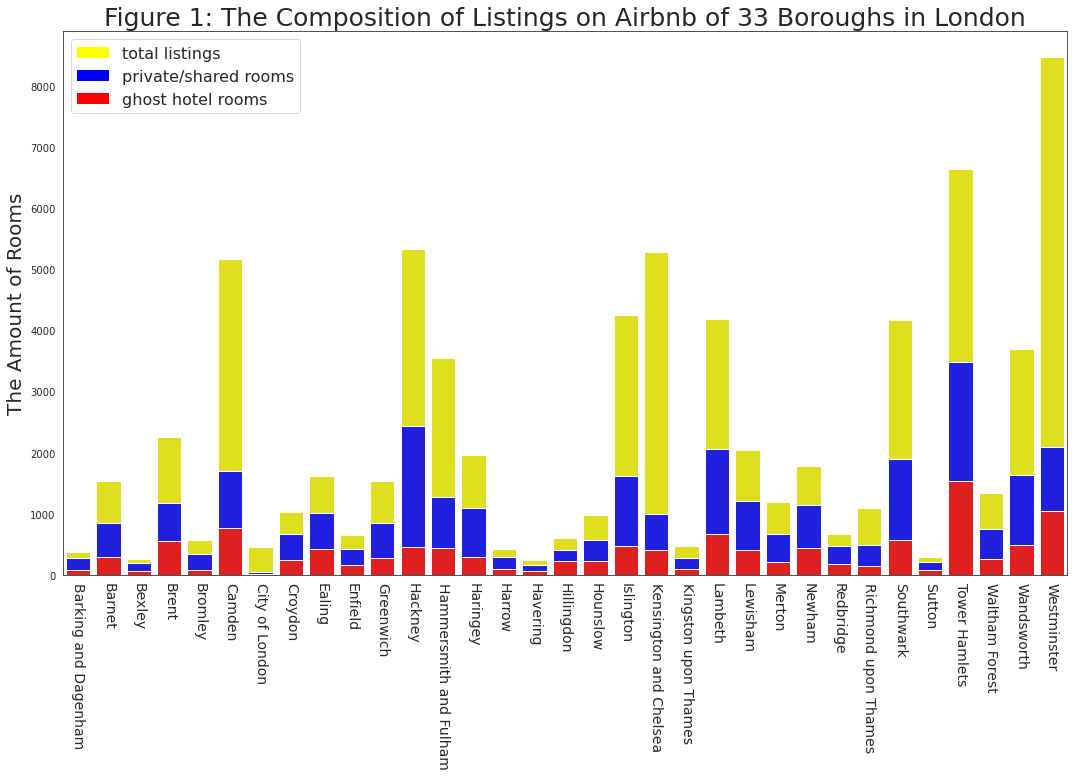

In [47]:
stackFigure()

Figure 2 make up the limitation stated above. The dots represents the locations of the ghost hotels and dots with a larger size and lighter colour indicate a ghost hotel with more rooms. From which we can see most of them gather in the central part of London. For the outer boroughs, especially in the east part, have sparse listings distribution. The colours indicate the ghost hotel room rate (the number of ghost hotel rooms divided by the total number of listings on Airbnb) around London. The warm-toned colours represent the high ghost room rate, while the cold-toned colours represent the low one. It is supposed to see that Hillington has the highest ghost hotel room rate. In the rest of the artical, we will focus more on two specific areas, one is Hillington (regions with the highest ghost hotel room rate (37%)) and the other is Tower Hamlets boroughs (with the most ghost hotels (391) and rooms (1529)). Their enlarged views is on the left and right bottom of the plot. 

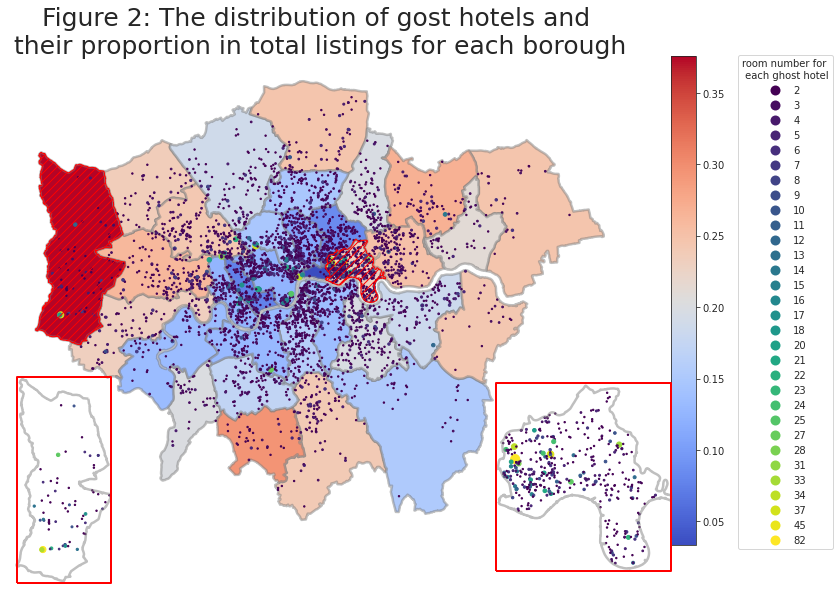

In [48]:
mainPlot()

### Revenue from ghost hotel
The way to calculated hosts’ revenue refers the Inside Airbnb's "San Francisco Model". It uses a review rates of 50% to convert reviews to estimated bookings. As for the average stays, a value of 3 nights per booking was used if a listing has a lower minimum nights value than 3, otherwise use the minimum nights value. Therefore, the monthly avenue is "reviews per month x nights per booking x price" / 50%". Using this method, we can get that the total monthly avenue of all ghost hotels is more than 4 billion pound and account for about 9.7% of total listings' avenue in Airbnb. Additionally, 13.4% (around 440,000 pound) of the local avenue from listings is earned by ghost hotels for Tower Hamlets, and approximately 20% (just over forty thousand pound) for Hillingdon.

### Comparison with the long-term monthly rent
The violin plots show the density distribution of 3(a) the average monthly price of ghost hotels and one-bedroom rent in London and 3(b) the monthly ghost hotel price for two boroughs. Figure 3(a) shows that ghost hotels have more extensive prices interval than the long-term rental price.The median point of monthly ghost hotels price is about 1.5 times of one bedroom rent, while the largest point is more than 2 times larger than the rent. For two boroughs, We can see that the price for both Tower Hamlets and Hillington are mainly within $2,000. However, Tower Hamlets has more expensive ghost rooms since it is more prosperous and locates closely to the city of London. The red line on the two violin plots is the local average rent of one bedroom in traditional rental market, it is a little lower than the median prices of ghost hotels in Hillingdon but higher than that of Tower Hamlets.  

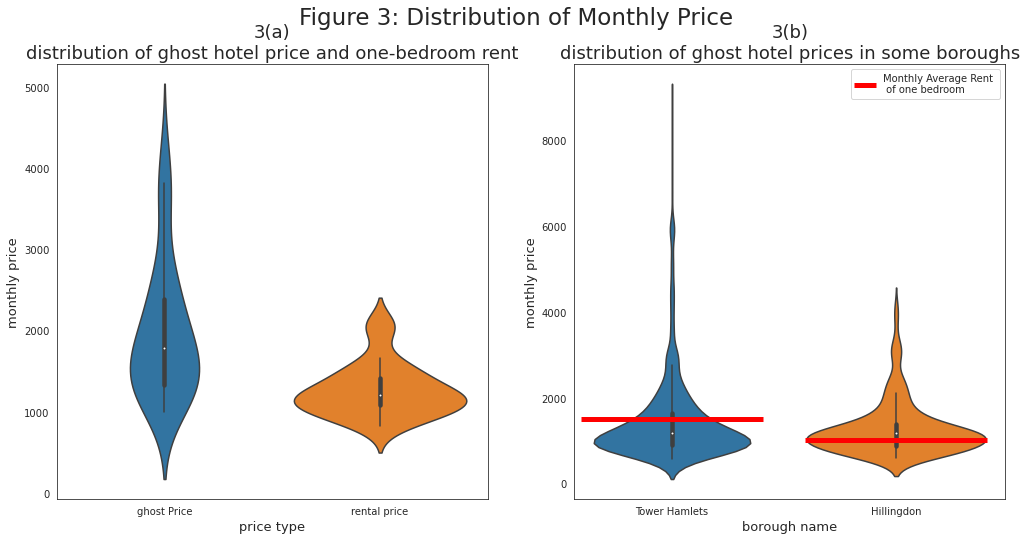

In [49]:
densityPlot()

The mean of ghost room price in different areas is also calculated. Tower Hamlets is the only region whose average ghost room price is a little lower than the one-bedroom rent, Hillingdon's ghost room price is 1.24 times larger and a few regions is even more than three times larger than the one-bedroom rent. The gap we find is smaller than the finding of Alexandridis et al.(2020). He discovered that the mean accommodation price in Airbnb, which seems to be stabilized around $60–$65 per night or $1800–$2000 per month is at least 3 times higher that the average monthly long-term rental price in Athens. The reason may related to the mismatching of our data time. One-bedroom data from Valuation Office Agency (VOA) is updated bi-annually, so the newest data is in 2019, while the Airbnb data is crawled in 2020 and its price might be greatly influence by COVID-19.
### The Effect on the Rental Market
Ghost hotels in Airbnb not only beat the traditional hotels on price but the convenient location (Airbnb can operate in residential neighbourhoods while traditional hotels can't do so because of zoning restrictions). However, these "unregulated form of hotel operation" have been repeatedly labelled as unfair competition by tourism-related authorities and registered hotel owners (Alexandridis et al., 2020, p.7). 
In addition, existing of ghost hotel will further remove the rental stock of London's housing market (Wieditz, 2017). A multiple regression model whose response variable is the average monthly rent in LTR market(also from VOA), and dependent variables are average monthly price in Airbnb and the number of ghost hotels in 33 London borough. Our purpose is to test the relationship between the average rent in traditional rental market and number of ghost rooms. Our result shows, when the number of ghost rooms increase by 1, the monthly average rent will increase 0.35 pound. Combining with the findings from the researcher mentioned above. we can say, the ghost hotels' booming raises the prices long-term rent by the damping of long-term rental market. More and more long-term tenants in London can’t afford rent(Gant, 2016). 

### Suggestions and recommendation
One of the critical short-term-rental proposals is that the property should be inhabited by either the owner or tenant to prevent Airbnb from reducing already-scarce long-term-housing rental supply (Betsy Powell, 2017). This action could effectively reduce the housing impact caused by ghost hotels. However, it's hard to chase whether the host obeys this rule all the time. Gold (2019) think the current policies are ineffective and inconsistently applied, so the law must be reformed to prevent "hotelization" of residential neighbourhoods and better secure access to the affordable housing stock. Therefore, except limiting the available nights per year for all kinds of properties, taxes imposed could also be adjusted to be similar to the local hotel and convex tax should be induced to those who own more listings.
### Reference
Airbnb Help Centre. (no date). ‘Responsible hosting in the United Kingdom’. Available at: 
https://www.airbnb.co.uk/help/article/1379/responsible-hosting-in-the-united-kingdom#taxes.

Alexandridis, G., Voutos, Y., Mylonas, P. and Caridakis, G. (2020). ‘A geolocation analytics-driven ontology for short-term leases: Inferring current sharing economy trends’. Algorithms. MDPI AG, 13 (3), p. 59. doi: 10.3390/a13030059.

Barron, K., Kung, E. and Proserpio, D. (2018). ‘The Sharing Economy and Housing Affordability: Evidence from Airbnb’. SSRN Electronic Journal. doi: 10.2139/ssrn.3006832.

Betsy Powell. (2017). ‘City looks to rein in Airbnb as neighbours wait in worry; Absentee landlords, “ghost hotels,” loss of housing concern critics of unregulated short-term rentals’. Toronto star, p. GT1.

Dunn, T. (2017). ‘How to fix Toronto’s short-term rental problems in 2017’. CBC News, 3 January. Available at: http://www.cbc.ca/news/canada/toronto/airbnb-regulation-2017-1.3909369.

Emily Mathieu. (2017). ‘“Ghost” kings of Kensington play havoc with tenants; Renters say landlords are forcing them out and turning apartments into Airbnb “ghost hotels”’. Toronto star, p. A1.

Gant, A. C. (2016). ‘Holiday rentals: The new gentrification battlefront’. Sociological Research Online. University of Surrey, 21 (3). doi: 10.5153/sro.4071.

Gold, A. E. (2019). ‘Community consequences of airbnb’. Washington Law Review. Seattle: Washington Law Review Association, 94 (4), pp. 1577–1637.

Hamari, J., Sjöklint, M. and Ukkonen, A. (2016). ‘The sharing economy: Why people participate in collaborative consumption’. Journal of the Association for Information Science and Technology, 67 (9), pp. 2047–2059. doi: 10.1002/asi.23552.

Houlder, V. (2017). ‘Airbnb’s edge on room prices depends on tax advantages’. Financial Times. Available at: https://www.ft.com/content/73102c20-c60e-11e6-9043-7e34c07b46ef.

Raju Gajurel. (2018). ‘Tax on Airbnb Income’. Available at: https://www.ukpropertyaccountants.co.uk/tax-airbnb-income/.

Wachsmuth, D., Chaney, D., Kerrigan, D., Shillolo, A. and Basalaev-Binder, R. (2018). The high cost of short-term rentals in New York City.

Wieditz, T. (2017). ‘Squeezed Out: Airbnb’s Commercialization of Home-Sharing in Toronto’. Policy report prepared for FAIRBNB.CA Coalition.









### READ ME
The data file is large, and the calculations in the project is a little complex,so you may wait for more than 10 minutes.
What's more something might be wrong when runing(because of network and some system reason). When this happens, re-run the whole file
might be useful (in extreme cases, you might need to "vagrant halt" and "vagrant up" again. It happens for one time among more than 20 times' rerun).

Because of my fault, i submit the file in the last minute and then something is wrong with the moodle system. I emailed you and since i did not get the response from you (i guessed the result since you have told us not to submit in the last minutes, and it's totally my fault), i decided to try my best to perfect the work within 2 days (the penalty for one minutes and two days are the same, and that's why i submited one-day later).

Thanks for your hardwork for the last semester. I learned a lot from your teaching and hope you could be a little little proud of my work. Sorry again for the
late submission and hope to see you in reality!